# GRAPE First Order, Implementing Single Qubit Rotation
Ref: https://github.com/qutip/qutip-notebooks/blob/master/examples/control-grape-single-qubit-rotation.ipynb

## Import libraries

In [25]:
import matplotlib.pyplot as plt
import time
import numpy as np
from qutip import *
from qutip.control import *
from qutip_qip.operations import rz, rx
from qutip import QobjEvo, Options
%matplotlib inline

## Define Constants and Hamiltonian

In [26]:
T = 2 * np.pi # Period
times = np.linspace(0, T, 500)
theta, phi = np.random.rand(2)

#Target unitary
U = rz(theta) * rx(phi)
U

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.90163072-0.43114131j -0.01481405-0.03098011j]
 [ 0.01481405-0.03098011j  0.90163072+0.43114131j]]

In [27]:
times.dtype

dtype('float64')

In [28]:
R = 500 # Number of learning iterations
H_ops = [sigmax(), sigmay(), sigmaz()] # Control Hamiltonians
H_labels = [r'$u_{x}$', r'$u_{y}$', r'$u_{z}$']
H0 = 0 * np.pi * sigmaz() # Drift Hamiltonian

In [29]:
u0 = np.array([np.random.rand(len(times)) * 2 * np.pi * 0.005 for _ in range(len(H_ops))])

u0 = [np.convolve(np.ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]

## GRAPE

In [30]:
from qutip.control.grape import plot_grape_control_fields, grape_unitary, grape_unitary_adaptive
from qutip.control.grape import _overlap
from qutip.ui.progressbar import TextProgressBar as ProgressBar

In [31]:
u_limits = None
alpha = None
eps = 2 * np.pi * 0.01

In [32]:
result = grape_unitary(U, H0, H_ops, R, times, u_start=u0, u_limits=u_limits,
                       eps=eps,
                       alpha=alpha,
                       progress_bar=ProgressBar(R),
                       phase_sensitive=False
                       )


10.0%. Run time:  10.18s. Est. time left: 00:00:01:31
20.0%. Run time:  21.34s. Est. time left: 00:00:01:25
30.0%. Run time:  32.69s. Est. time left: 00:00:01:16
40.0%. Run time:  43.78s. Est. time left: 00:00:01:05
50.0%. Run time:  54.22s. Est. time left: 00:00:00:54
60.0%. Run time:  63.84s. Est. time left: 00:00:00:42
70.0%. Run time:  72.79s. Est. time left: 00:00:00:31
80.0%. Run time:  81.79s. Est. time left: 00:00:00:20
90.0%. Run time:  91.79s. Est. time left: 00:00:00:10
Total run time: 102.07s


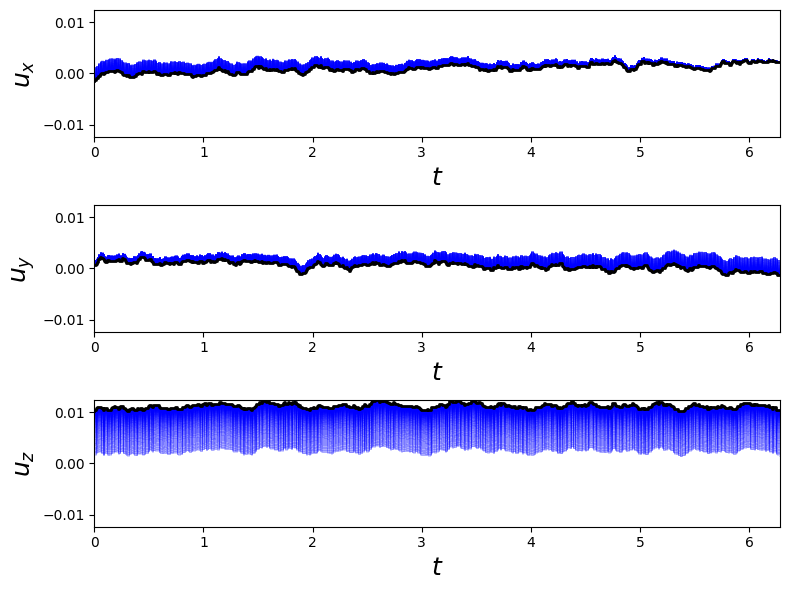

In [33]:
plot_grape_control_fields(times, result.u / (2 * np.pi), H_labels, uniform_axes=True);

## Fidelity and Overlap b/w ideal and optimized

In [34]:
U

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.90163072-0.43114131j -0.01481405-0.03098011j]
 [ 0.01481405-0.03098011j  0.90163072+0.43114131j]]

In [35]:
result.U_f

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.90268781-0.42886546j -0.01545522-0.0314686j ]
 [ 0.01545522-0.0314686j   0.90268781+0.42886546j]]

In [36]:
result.U_f/result.U_f[0,0]

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.00000000e+00+0.j         -4.56004758e-04-0.03507765j]
 [ 2.74808133e-02-0.02180491j  6.31696135e-01+0.77521609j]]

In [37]:
_overlap(U, result.U_f).real, abs(_overlap(U, result.U_f))**2

(0.999996526689205, 0.999993053390474)

## Verify the Correctmess of the Hamiltonian Pulses by Integration

In [38]:
# Convert Qobj to QobjEvo
H_t_evo = QobjEvo(result.H_t, tlist=times)

In [42]:
c_ops = []
U_f_num = propagator(H_t_evo, times[-1], c_ops,args={}) 

In [43]:
_overlap(result.U_f, U_f_num).real, abs(_overlap(result.U_f, U_f_num))**2

(0.9999999937924873, 0.9999999875849745)

## Bloch Sphere

In [45]:
psi0 = basis(2, 0)
e_ops = [sigmax(), sigmay(), sigmaz()]

In [46]:
me_result = mesolve(result.H_t, psi0, times, c_ops, e_ops)

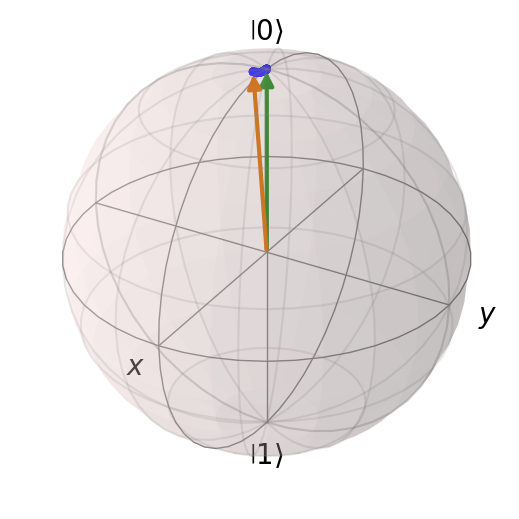

In [50]:
b = Bloch()

b.add_points(me_result.expect)

b.add_states(psi0)
b.add_states(U * psi0)
b.render()
b.show()

## Tomography

In [51]:
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]]
op_label = [["i", "x", "y", "z"]]

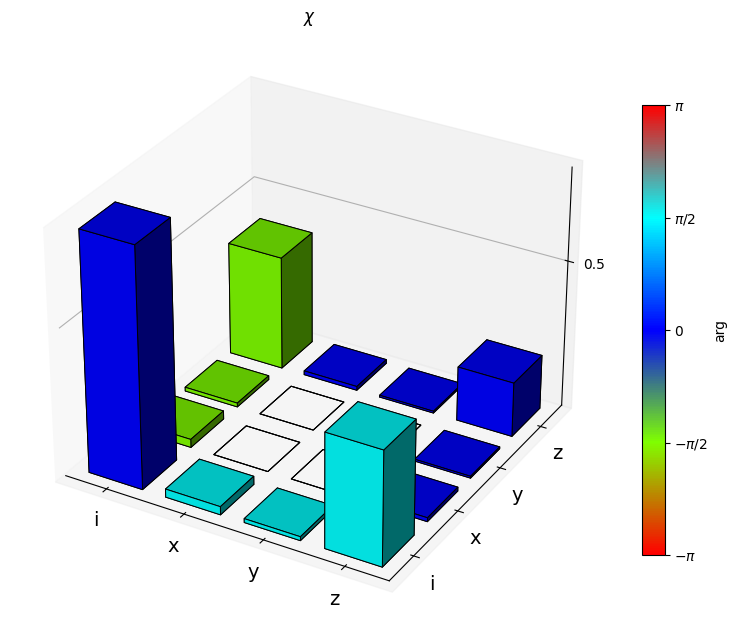

In [52]:
fig = plt.figure(figsize=(8,6))

U_ideal = spre(U) * spost(U.dag())

chi = qpt(U_ideal, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)